In [1]:
import nextnanopy as nn
import os
import matplotlib.pyplot as plt
import numpy as np
import sys


In [2]:
path_nextnanoprojects_tools = r"C:\Users\sp6497_a\nextnanopy_projects"

In [3]:
print(sys.path)
sys.path.append(path_nextnanoprojects_tools)
print(sys.path)
from nextnano_tools.helper_functions import build_output
from nextnano_tools.simstructs import SimOut, BandStructure, Eigenstate

['c:\\Users\\sp6497_a\\miniconda3\\envs\\nextnanodev\\python313.zip', 'c:\\Users\\sp6497_a\\miniconda3\\envs\\nextnanodev\\DLLs', 'c:\\Users\\sp6497_a\\miniconda3\\envs\\nextnanodev\\Lib', 'c:\\Users\\sp6497_a\\miniconda3\\envs\\nextnanodev', '', 'c:\\Users\\sp6497_a\\miniconda3\\envs\\nextnanodev\\Lib\\site-packages', 'c:\\Users\\sp6497_a\\miniconda3\\envs\\nextnanodev\\Lib\\site-packages\\win32', 'c:\\Users\\sp6497_a\\miniconda3\\envs\\nextnanodev\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\sp6497_a\\miniconda3\\envs\\nextnanodev\\Lib\\site-packages\\Pythonwin']
['c:\\Users\\sp6497_a\\miniconda3\\envs\\nextnanodev\\python313.zip', 'c:\\Users\\sp6497_a\\miniconda3\\envs\\nextnanodev\\DLLs', 'c:\\Users\\sp6497_a\\miniconda3\\envs\\nextnanodev\\Lib', 'c:\\Users\\sp6497_a\\miniconda3\\envs\\nextnanodev', '', 'c:\\Users\\sp6497_a\\miniconda3\\envs\\nextnanodev\\Lib\\site-packages', 'c:\\Users\\sp6497_a\\miniconda3\\envs\\nextnanodev\\Lib\\site-packages\\win32', 'c:\\Users\\sp6497_a\\min

In [ ]:
#growthsheet translation functions

def compute_x_arrays(period_layers, repeat_periods=1):
    
    #Returns four arrays (lists) in nm:
      #algaas_x_start, algaas_x_end, gaas_x_start, gaas_x_end
    
    # Repeat the period
    layers = period_layers * repeat_periods

    x = 0.0  # nm
    algaas_x_start, algaas_x_end = [], []
    gaas_x_start, gaas_x_end = [], []

    for lyr in layers:
        t_nm = float(lyr['thickness_A']) * 0.1  # Convert Å to nm
        x_start, x_end = round(x, ndigits=4), round(x + t_nm, ndigits=4)

        mat = lyr['material'].strip().lower()
        if mat == 'algaas' or mat.startswith('al') and 'gaas' in mat:
            algaas_x_start.append(x_start)
            algaas_x_end.append(x_end)
        elif mat == 'gaas':
            gaas_x_start.append(x_start)
            gaas_x_end.append(x_end)
        else:
            # If you have other materials, add branches as needed.
            pass

        x = x_end

    return algaas_x_start, algaas_x_end, gaas_x_start, gaas_x_end

def format_region_block_compact(material, x_start_nm, x_end_nm, al_alloy_var='$Al_alloy'):
    """
    Build one compact region block for the given material and interval [x_start_nm, x_end_nm].
    Example:
    region{line{ x=[0,8.5]} binary{name="GaAs"}}
    or
    region{line{ x=[0,8.5]} ternary_constant{name="Al(x)Ga(1-x)As" alloy_x=$Al_alloy}}
    """
    def fmt(x):
        return f"{x:.6f}".rstrip('0').rstrip('.')

    if material.lower() == 'gaas':
        return f'region{{line{{ x=[{fmt(x_start_nm)},{fmt(x_end_nm)}]}} binary{{name="GaAs"}}}}\n'
    elif material.lower() == 'algaas':
        return f'region{{line{{ x=[{fmt(x_start_nm)},{fmt(x_end_nm)}]}} ternary_constant{{name="Al(x)Ga(1-x)As" alloy_x={al_alloy_var}}}}}\n'
    else:
        return f'region{{line{{ x=[{fmt(x_start_nm)},{fmt(x_end_nm)}]}} binary{{name="{material}"}}}}\n'


def build_all_region_blocks_compact(algaas_x_start, algaas_x_end, gaas_x_start, gaas_x_end, al_alloy_var='$Al_alloy'):
    """
    Generate all region blocks in compact single-line format.
    """
    intervals = []
    intervals += [('AlGaAs', s, e) for s, e in zip(algaas_x_start, algaas_x_end)]
    intervals += [('GaAs', s, e) for s, e in zip(gaas_x_start, gaas_x_end)]
    intervals.sort(key=lambda t: t[1])  # sort by start position

    return ''.join(format_region_block_compact(mat, xs, xe, al_alloy_var) for mat, xs, xe in intervals)

In [ ]:
"""
Build x-start and x-end arrays for GaAs and AlGaAs layers from a growthsheet in Å.
Results are in nm.

Customize:
- period_layers: list of dicts for ONE period (Active + Injection)
- REPEAT_PERIODS: how many times to repeat that period

Layer dict format:
{
  'material': 'GaAs' or 'AlGaAs',   # required
  'thickness_A': <float in anstroms>,  # required
  # optional:
  'dope_e17':                    # if tracking doping
}
"""

# ---------- CONFIG ----------
REPEAT_PERIODS = 2
al_x_fixed = 0.45

period_layers = [
    # Active Region (thickness_A = nm * 10)
    {'material': 'AlGaAs', 'al_x': al_x_fixed, 'thickness_A': 8.5 },
    {'material': 'GaAs',                 'thickness_A': 53.7},
    {'material': 'AlGaAs', 'al_x': al_x_fixed, 'thickness_A': 5.7},
    {'material': 'GaAs',                 'thickness_A': 50.9},
    {'material': 'AlGaAs', 'al_x': al_x_fixed, 'thickness_A': 5.7},
    {'material': 'GaAs',                 'thickness_A': 82.0},
    {'material': 'AlGaAs', 'al_x': al_x_fixed, 'thickness_A': 39.6},

    # Injection Region
    {'material': 'GaAs',                 'thickness_A': 33.9 },
    {'material': 'AlGaAs', 'al_x': al_x_fixed, 'thickness_A': 34.0},
    {'material': 'GaAs',                 'thickness_A': 33.9},
    {'material': 'AlGaAs', 'al_x': al_x_fixed, 'thickness_A': 22.6},

    {'material': 'GaAs',                 'thickness_A': 36.7},
    {'material': 'AlGaAs', 'al_x': al_x_fixed, 'thickness_A': 28.3},
    {'material': 'GaAs',                 'thickness_A': 42.4},
    {'material': 'AlGaAs', 'al_x': al_x_fixed, 'thickness_A': 18.4},
    {'material': 'GaAs',                 'thickness_A': 52.3},
    {'material': 'AlGaAs', 'al_x': al_x_fixed, 'thickness_A': 14.1},
    {'material': 'GaAs',                 'thickness_A': 56.5},
]

# Run
algaas_x_start, algaas_x_end, gaas_x_start, gaas_x_end = compute_x_arrays(
    period_layers, repeat_periods=REPEAT_PERIODS
)

print(f"AlGaAs layers: {len(algaas_x_start)}  | GaAs layers: {len(gaas_x_start)}")
print(f"Total length: {max(algaas_x_end + gaas_x_end):.3f} nm")


AlGaAs layers: 18  | GaAs layers: 18
Total length: 123.840 nm


In [6]:
print("$AlGaAs_x_starts=", algaas_x_start)
print("$AlGaAs_x_ends=", algaas_x_end)
print("$GaAs_x_starts=", gaas_x_start)
print("$GaAs_x_ends=", gaas_x_end)

$AlGaAs_x_starts= [0.0, 6.22, 11.88, 20.65, 28.0, 34.79, 40.72, 47.79, 54.86, 61.92, 68.14, 73.8, 82.57, 89.92, 96.71, 102.64, 109.71, 116.78]
$AlGaAs_x_ends= [0.85, 6.79, 12.45, 24.61, 31.4, 37.05, 43.55, 49.63, 56.27, 62.77, 68.71, 74.37, 86.53, 93.32, 98.97, 105.47, 111.55, 118.19]
$GaAs_x_starts= [0.85, 6.79, 12.45, 24.61, 31.4, 37.05, 43.55, 49.63, 56.27, 62.77, 68.71, 74.37, 86.53, 93.32, 98.97, 105.47, 111.55, 118.19]
$GaAs_x_ends= [6.22, 11.88, 20.65, 28.0, 34.79, 40.72, 47.79, 54.86, 61.92, 68.14, 73.8, 82.57, 89.92, 96.71, 102.64, 109.71, 116.78, 123.84]


In [7]:

region_text = build_all_region_blocks_compact(algaas_x_start, algaas_x_end, gaas_x_start, gaas_x_end)
print(region_text)




region{line{ x=[0,0.85]} ternary_constant{name="Al(x)Ga(1-x)As" alloy_x=$Al_alloy}}
region{line{ x=[0.85,6.22]} binary{name="GaAs"}}
region{line{ x=[6.22,6.79]} ternary_constant{name="Al(x)Ga(1-x)As" alloy_x=$Al_alloy}}
region{line{ x=[6.79,11.88]} binary{name="GaAs"}}
region{line{ x=[11.88,12.45]} ternary_constant{name="Al(x)Ga(1-x)As" alloy_x=$Al_alloy}}
region{line{ x=[12.45,20.65]} binary{name="GaAs"}}
region{line{ x=[20.65,24.61]} ternary_constant{name="Al(x)Ga(1-x)As" alloy_x=$Al_alloy}}
region{line{ x=[24.61,28]} binary{name="GaAs"}}
region{line{ x=[28,31.4]} ternary_constant{name="Al(x)Ga(1-x)As" alloy_x=$Al_alloy}}
region{line{ x=[31.4,34.79]} binary{name="GaAs"}}
region{line{ x=[34.79,37.05]} ternary_constant{name="Al(x)Ga(1-x)As" alloy_x=$Al_alloy}}
region{line{ x=[37.05,40.72]} binary{name="GaAs"}}
region{line{ x=[40.72,43.55]} ternary_constant{name="Al(x)Ga(1-x)As" alloy_x=$Al_alloy}}
region{line{ x=[43.55,47.79]} binary{name="GaAs"}}
region{line{ x=[47.79,49.63]} ternary_

In [8]:
bias = r'bias_00000'
quantum_region = r'Quantum\quantum_region'
quantum_band = r'kp8'
quantum_band_interactions = r'kp8_kp8'

C:\Users\sp6497_a\nextnano_outs\Output\P4-20-21-1W3(11)\bias_00000\OpticsQuantum\quantum_region


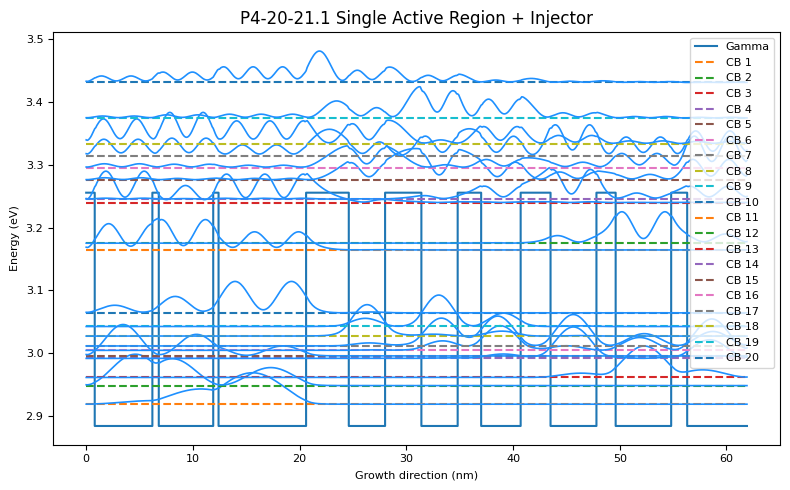

<BandStructure name=CB, 20 subbands: [2.9191 eV, 2.9486 eV, 2.9617 eV, 2.9919 eV, 2.9958 eV, 3.0048 eV, 3.0117 eV, 3.0274 eV, 3.0427 eV, 3.0644 eV, 3.1645 eV, 3.1753 eV, 3.2399 eV, 3.2454 eV, 3.2759 eV, 3.2956 eV, 3.3136 eV, 3.3334 eV, 3.3743 eV, 3.4310 eV]>

In [ ]:
parent_dir = r'C:\Users\sp6497_a\nextnano_outs\Output\P4-20-21-1W3(11)'
VB_cutoff = 2
singleperiod = build_output(parent_dir,quantum_region,quantum_band,quantum_band_interactions,bias,VB_cutoff,14)
singleperiod.bands['CB'].sort_subbands(decreasing=False)
singleperiod.bands['CB'].plot_band(title_diff='P4-20-21.1 Single Active + Injector',normalize_y=True,show_legend=True,fontsizebase=8,fontsizetitle=12)

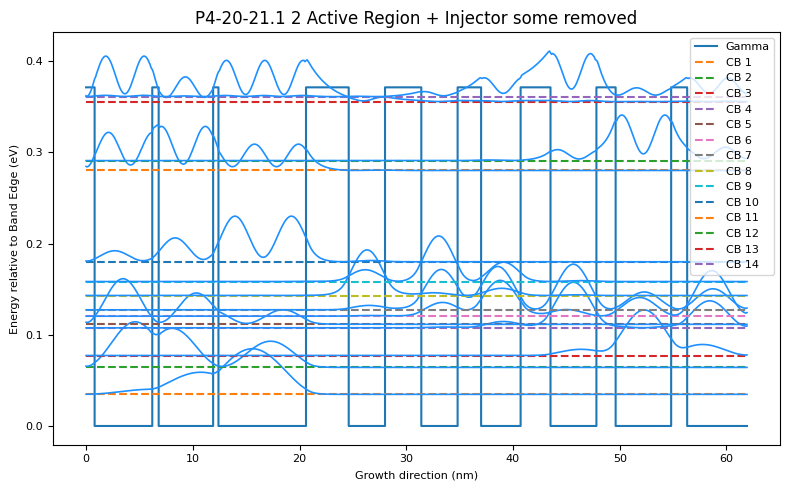

<Axes: title={'center': 'P4-20-21.1 2 Active Region + Injector some removed'}, xlabel='Growth direction (nm)', ylabel='Energy relative to Band Edge (eV)'>

In [ ]:
singleperiod.bands['CB'].remove_subband(index=20)
singleperiod.bands['CB'].remove_subband(index=19)
singleperiod.bands['CB'].remove_subband(index=18)
singleperiod.bands['CB'].remove_subband(index=17)
singleperiod.bands['CB'].remove_subband(index=16)
singleperiod.bands['CB'].remove_subband(index=15)
# singleperiod.bands['CB'].remove_subband(index=1)
singleperiod.bands['CB'].plot_band(title_diff='P4-20-21.1 2 Active Region + Injector some removed',normalize_y=True,show_legend=False,fontsizebase=8,fontsizetitle=12)

C:\Users\sp6497_a\nextnano_outs\Output\P4-20-21-1W3(13)\bias_00000\OpticsQuantum\quantum_region


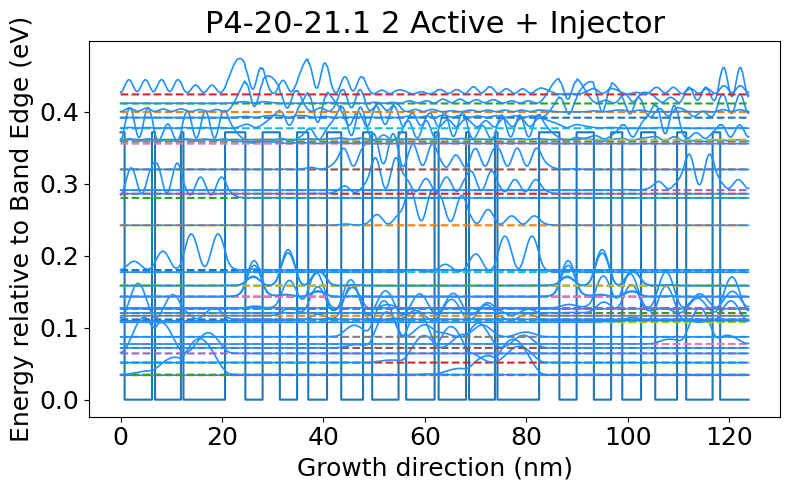

In [ ]:
parent_dir = r'C:\Users\sp6497_a\nextnano_outs\Output\P4-20-21-1W3(13)'
VB_cutoff = 2
simout2repeat = build_output(parent_dir,quantum_region,quantum_band,quantum_band_interactions,bias,VB_cutoff,14)
simout2repeat.bands['CB'].sort_subbands(decreasing=False)
simout2repeat.bands['CB'].plot_band(title_diff='P4-20-21.1 2 Active + Injector',normalize_y=True,show_legend=False)
simout2repeat.bands['CB'].remove_subband(index=33)
simout2repeat.bands['CB'].remove_subband(index=32)
simout2repeat.bands['CB'].remove_subband(index=31)
simout2repeat.bands['CB'].remove_subband(index=30)
simout2repeat.bands['CB'].remove_subband(index=29)
simout2repeat.bands['CB'].plot_band(title_diff='P4-20-21.1 2 Active + Injector',normalize_y=True,show_legend=False)